In [14]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.plotting.marker_plot import marker_plot

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [49]:
def marker_plot(ds: loompy.LoomConnection, out_file: str, markers: list, lay: str = 'smooth', embedding: str = "TSNE") -> None:
    '''
    Generates a multi-panel plot to inspect UMI and Bin counts.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    n_cells = ds.shape[1]
    
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (1000 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(16,np.ceil(nM/5)*4))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## GA score    
        v = ds[lay][ds.ra['Gene'] == m, :][0]
        k = v > 0
        GA = v[k]
        q = np.quantile(v, 0.99)
        
        ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
        im = ax.scatter(pos[k,0], pos[k,1], cmap='viridis', c=GA, vmax = q, marker='.', lw=0, s=epsilon)
        
        fig.colorbar(im, ax=ax, orientation='vertical')
        ax.set_title(f'{m}:  {ds.ra.loc[ds.ra.Gene == m]}', fontdict={'fontsize': 8, 'fontweight': 'medium'})
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

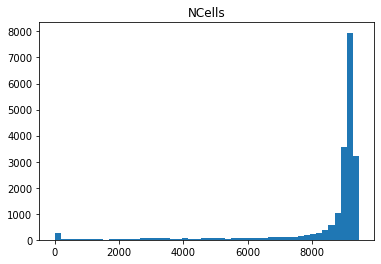

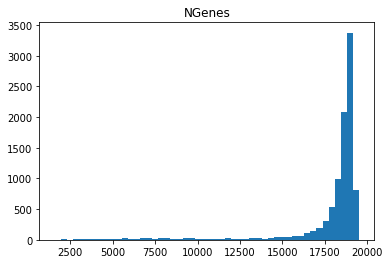

10:41:13 INFO     Total 19560 valids


['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 'OLIG2', 'ETV5', 'IRX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 'SALL2', 'OTX2', 'HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2', 'NEUROD6', 'ZNF33A', 'PHTF1', 'LMX1A']


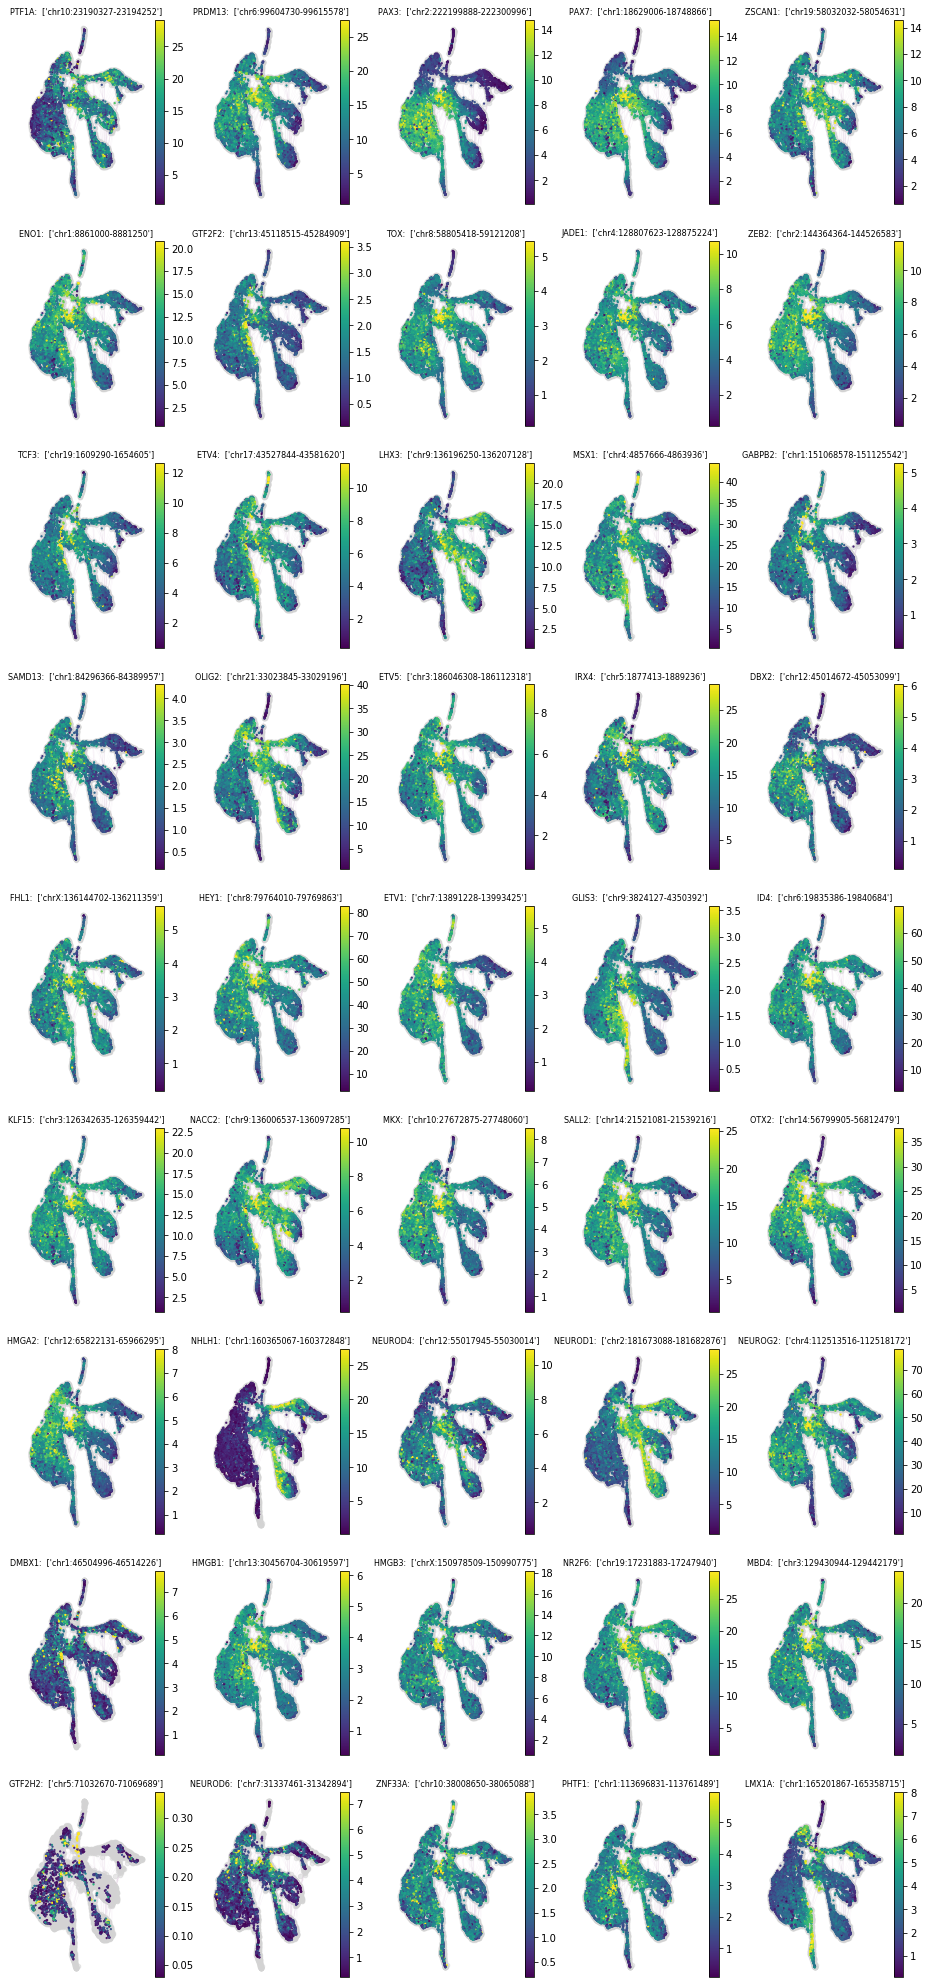

In [51]:
build = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/'
with loompy.connect(os.path.join(build, 'Midbrain_GA.loom')) as ds:
    lay = 'smooth'
    NCells = ds[lay].map([np.count_nonzero], axis=0)[0]
    NGenes = ds[lay].map([np.count_nonzero], axis=1)[0]
    plt.hist(NCells, bins = 50)
    plt.title('NCells')
    plt.show()
    plt.hist(NGenes, bins = 50)
    plt.title('NGenes')
    plt.show()
    
    valids = ds.ra['Gene'][NCells > 1000]
    logging.info(f'Total {len(valids)} valids')
    
    markers = ['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 
               'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 'OLIG2', 'ETV5', 'IRX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 
               'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 'SALL2', 'OTX2', 'HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 
               'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2', 'NEUROD6', 'ZNF33A', 'PHTF1', 'LMX1A']
#     markers = ['PAX3', 'ZEB2', 'NEUROD6', 'FOXA2', 'TEAD2']
    plot_markers = [x for x in markers if x in valids]
    print(plot_markers)
    marker_plot(ds, os.path.join(build, 'exported/marker_plot.png'), markers = markers, lay= lay, embedding = 'UMAP')

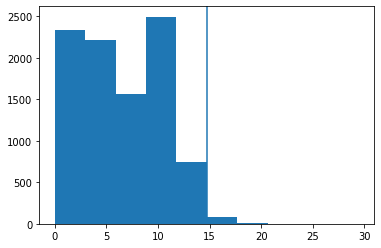

In [48]:
build = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/'
with loompy.connect(os.path.join(build, 'Midbrain_GA.loom')) as ds:
    vals = ds['smooth'][ds.ra['Gene'] == 'PAX3', :][0]
    q = np.quantile(vals, 0.99)
    plt.hist(vals)
    plt.axvline(q)

In [27]:
with loompy.connect(os.path.join(build, 'Midbrain_GA.loom')) as ds:
    ids = np.where(np.in1d(ds.ra['Gene'], markers))[0]
    gs = ds.ra['Gene', 'loc'][ids,:]
    loc = np.array([x.split(':') for x in gs[:,1]])
    lns = [x.split('-') for x in loc[:,1]]
    lns = [abs(int(x[0]) - int(x[1])) for x in lns]
gs = np.vstack((gs.T, lns)).T
# gs[:,[0,2]]
gs

array([['ETV1', 'chr7:13891228-13993425', 102197],
       ['PAX7', 'chr1:18629006-18748866', 119860],
       ['FHL1', 'chrX:136144702-136211359', 66657],
       ['HMGB3', 'chrX:150978509-150990775', 12266],
       ['TCF3', 'chr19:1609290-1654605', 45315],
       ['ENO1', 'chr1:8861000-8881250', 20250],
       ['JADE1', 'chr4:128807623-128875224', 67601],
       ['LHX3', 'chr9:136196250-136207128', 10878],
       ['GLIS3', 'chr9:3824127-4350392', 526265],
       ['PRDM13', 'chr6:99604730-99615578', 10848],
       ['IRX4', 'chr5:1877413-1889236', 11823],
       ['PHTF1', 'chr1:113696831-113761489', 64658],
       ['NEUROD4', 'chr12:55017945-55030014', 12069],
       ['MBD4', 'chr3:129430944-129442179', 11235],
       ['PAX3', 'chr2:222199888-222300996', 101108],
       ['GABPB2', 'chr1:151068578-151125542', 56964],
       ['GTF2H2', 'chr5:71032670-71069689', 37019],
       ['NACC2', 'chr9:136006537-136097285', 90748],
       ['HMGA2', 'chr12:65822131-65966295', 144164],
       ['MKX', 'c

In [115]:
# markers = ['TNC', 'TOP2A', 'EOMES', 'CLDN5', 'CD248', 'NTN1', 
#            'HMGB2', 'NEUROD1', 'NKX6-2', 'FOXD2', 'MEIS2', 'GATA3', 
#            'POU4F1', 'ALDH1A1', 'RHBDD1', 'LRRC10B', 'PRDM13', 'CXCR4', 
#            'MSX1', 'DCX', 'RFX4']

markers = ['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 
           'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 
           'OLIG2', 'ETV5', 'RX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 
           'SALL2','HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2',
           'NEUROD6', 'ZNF33A', 'PHTF1']

# markers = ['MEOX1', 'PAX7', 'ETV1', 'FHL1', 'TACC3', 'VIM', 'NANOG', 'POU5F1B']
valids = ds.ra['Gene'][NCells > 100]
[print(x) for x in markers if x in valids]

TypeError: 'NoneType' object is not subscriptable

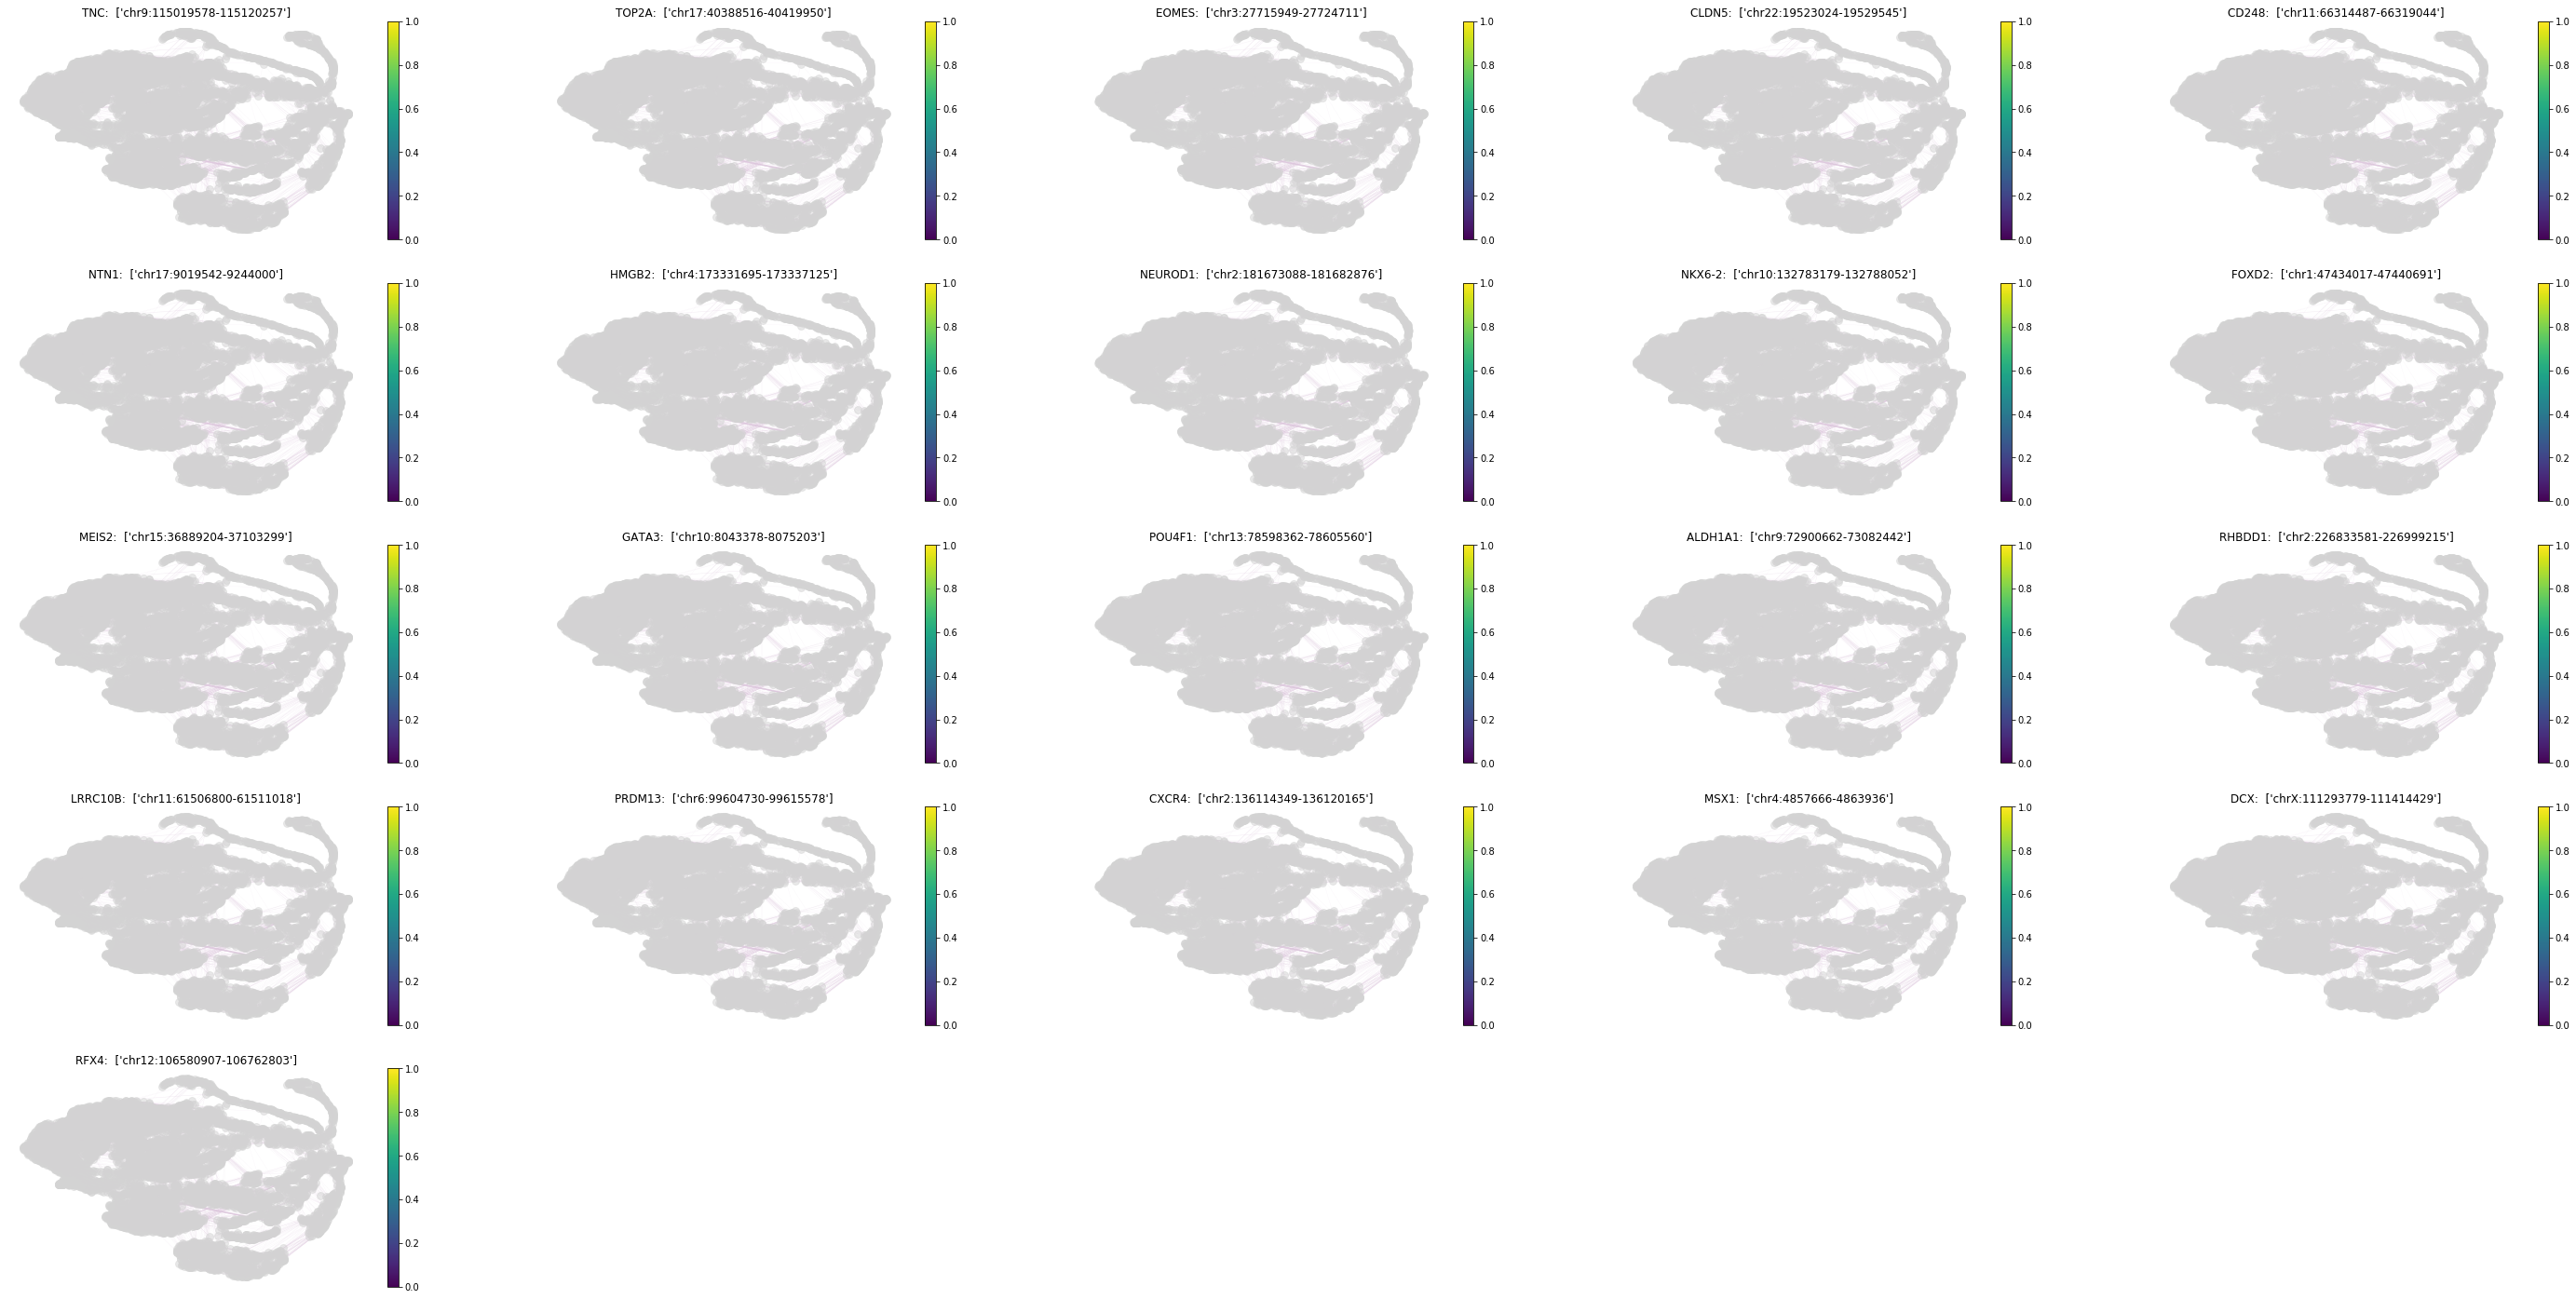

In [69]:
marker_plot(ds, '/data/proj/scATAC/chromograph/build_20200216/exported/marker_plot.png', markers = markers, lay= 'smooth', embedding = 'UMAP')

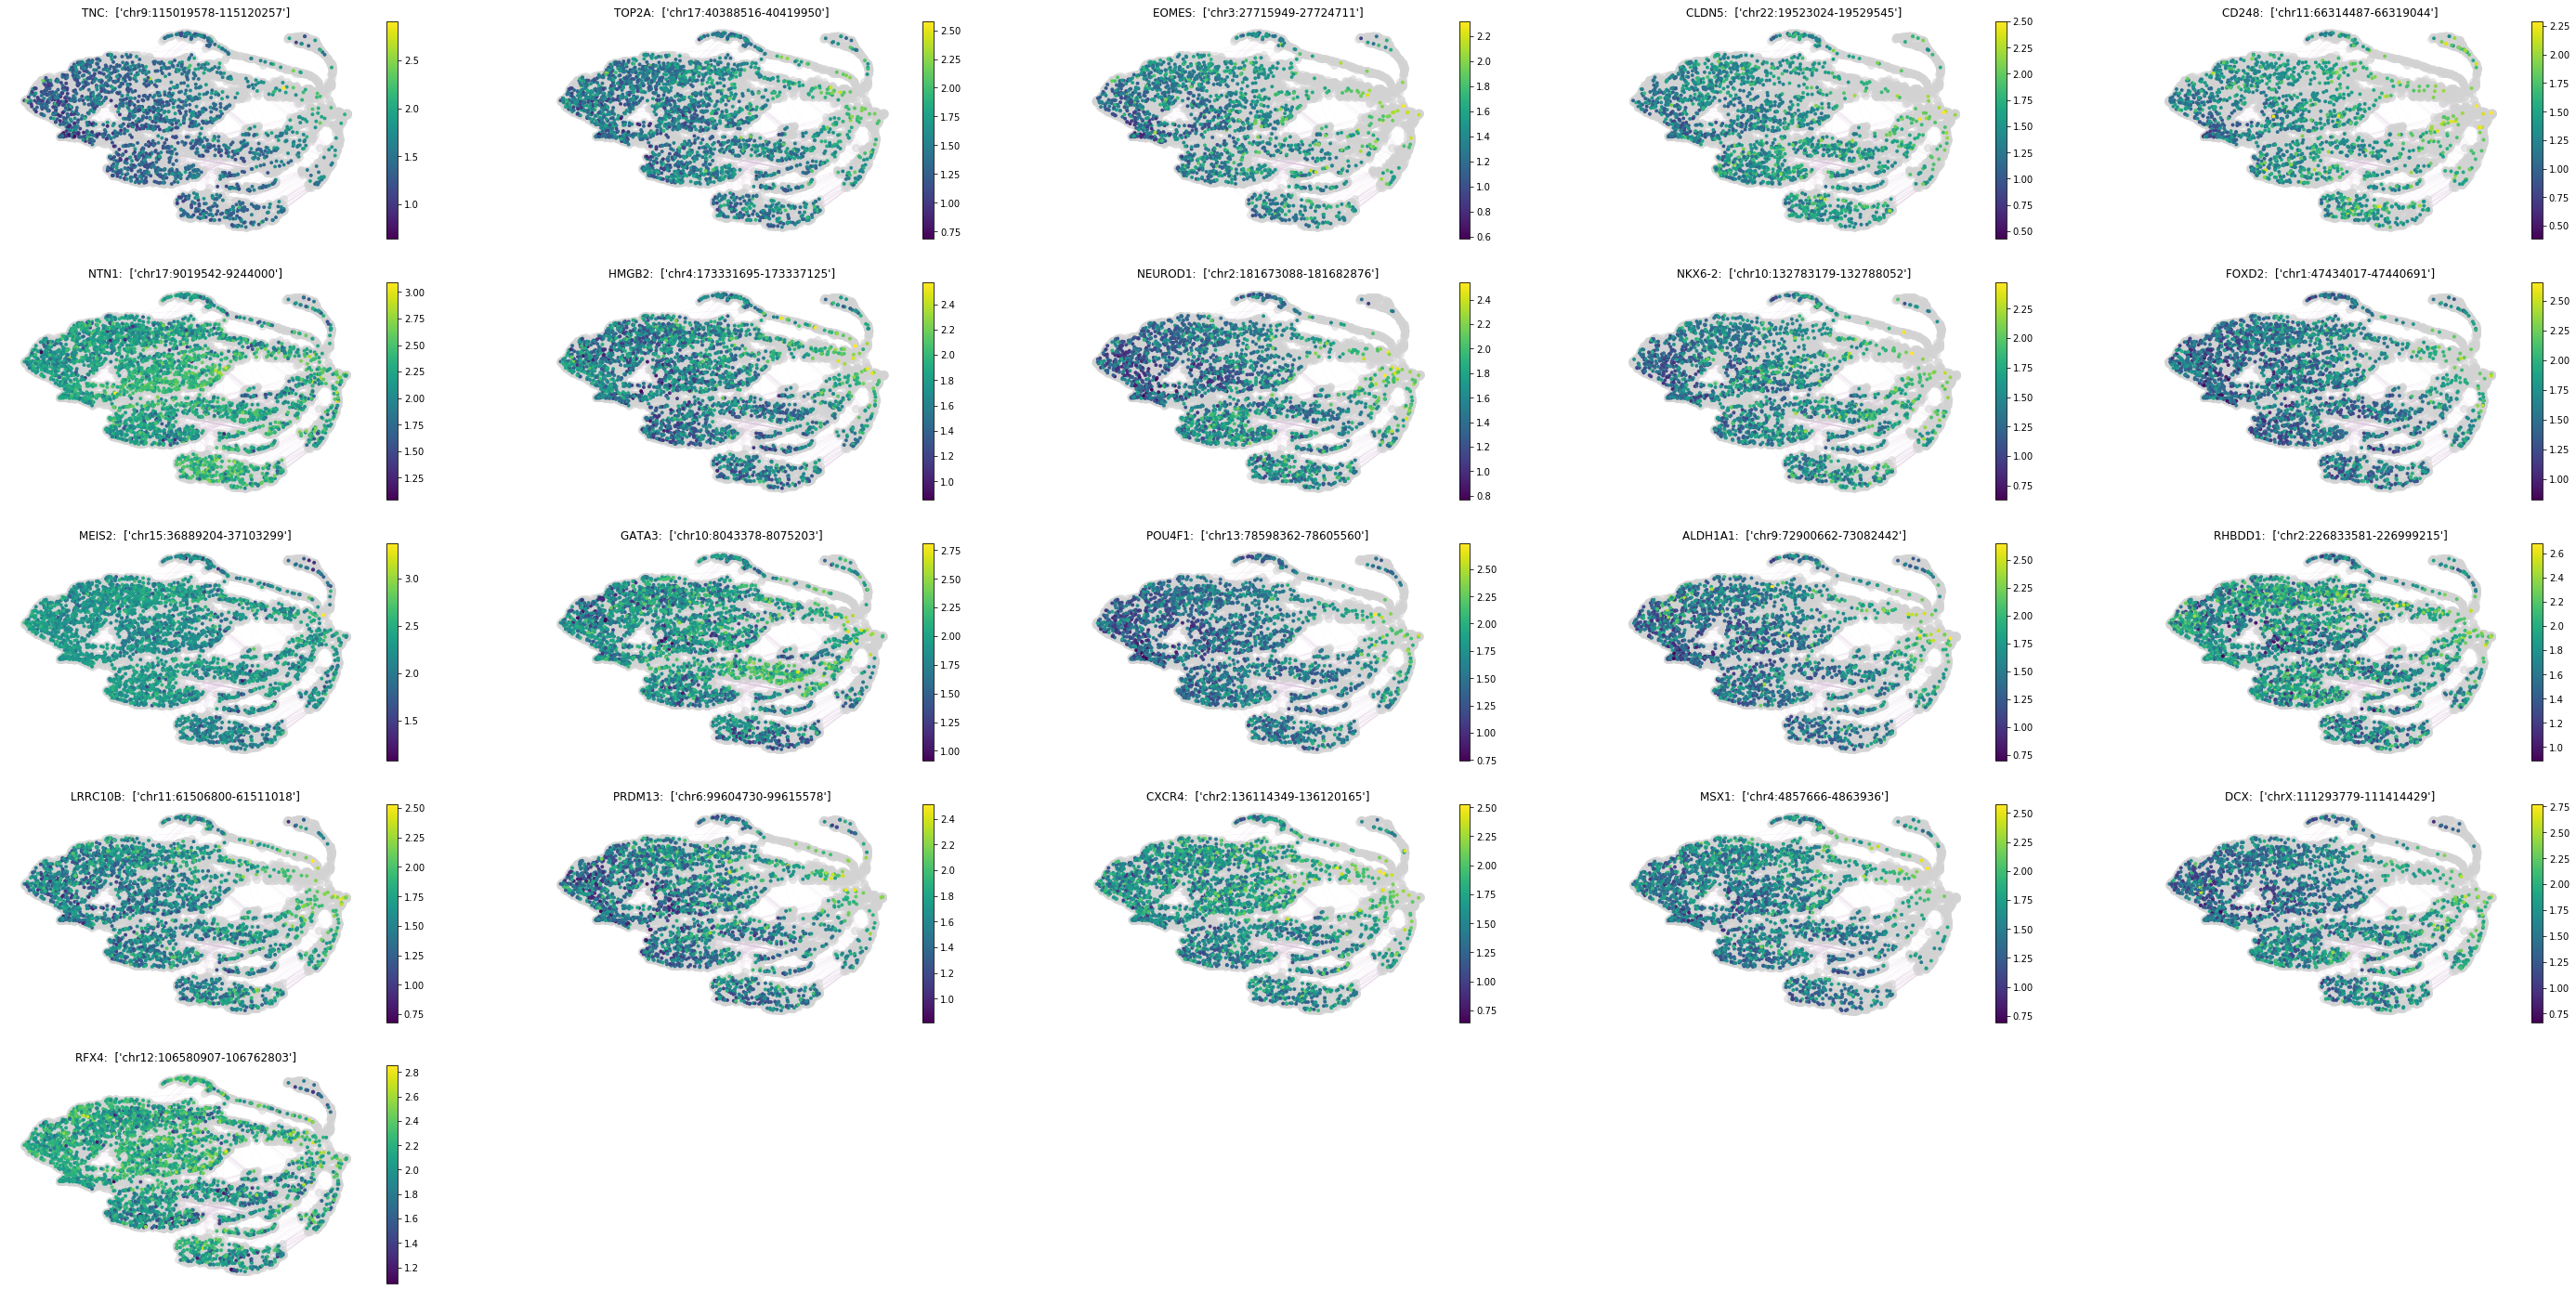

In [70]:
marker_plot(ds, '/data/proj/scATAC/chromograph/build_20200216/exported/marker_plot.png', markers = markers, lay= '', embedding = 'UMAP')

In [8]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter
from sklearn.neighbors import NearestNeighbors

import loompy

from cytograph.plotting.colors import colors75


def manifold2(ds: loompy.LoomConnection, out_file: str, tag1: List[str] = None, tag2: List[str] = None, embedding: str = "TSNE", cls: str = 'Clusters') -> None:
	n_cells = ds.shape[1]
	has_edges = False
	if "RNN" in ds.col_graphs:
		g = ds.col_graphs.RNN
		has_edges = True
	elif "MKNN" in ds.col_graphs:
		g = ds.col_graphs.MKNN
		has_edges = True
	if embedding in ds.ca:
		pos = ds.ca[embedding]
	else:
		raise ValueError("Embedding not found in the file")
	labels = ds.ca[cls]
	if "Outliers" in ds.col_attrs:
		outliers = ds.col_attrs["Outliers"]
	else:
		outliers = np.zeros(ds.shape[1])
	# Compute a good size for the markers, based on local density
	min_pts = 50
	eps_pct = 60
	nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
	nn.fit(pos)
	knn = nn.kneighbors_graph(mode='distance')
	k_radius = knn.max(axis=1).toarray()
	epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

	fig = plt.figure(figsize=(25, 10))
	ax = fig.add_axes([0, 0, 0.4, 1])

	# Draw edges
	if has_edges:
		lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
		ax.add_collection(lc)

	# Draw nodes
	plots = []
	tag1_names = []
	tag2_names = []
	for i in range(max(labels) + 1):
		cluster = labels == i
		n_cells = cluster.sum()
		if np.all(outliers[labels == i] == 1):
			edgecolor = colorConverter.to_rgba('red', alpha=.1)
			plots.append(plt.scatter(x=pos[outliers == 1, 0], y=pos[outliers == 1, 1], c='grey', marker='.', edgecolors=edgecolor, alpha=0.1, s=epsilon))
			tag1_names.append(f"{i}/n={n_cells}  (outliers)")
		else:
			plots.append(plt.scatter(x=pos[cluster, 0], y=pos[cluster, 1], c=[colors75[np.mod(i, 75)]], marker='.', lw=0, s=epsilon, alpha=0.5))
			txt = str(i)
			if "ClusterName" in ds.ca:
				txt = ds.ca.ClusterName[ds.ca[cls] == i][0]
			if tag1 is not None:
				tag1_names.append(f"{txt}/n={n_cells} " + tag1[i].replace("\n", " "))
			else:
				tag1_names.append(f"{txt}/n={n_cells}")
			if tag2 is not None:
				tag2_names.append(f"{txt} " + tag2[i].replace("\n", " "))
	
	# Add legends
	if ds.ca[cls].max() < 300:
		ax2 = fig.add_axes([0.4, 0, 0.3, 1])
		ax2.axis("off")
		ax2.legend(plots, tag1_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)
		if tag2 is not None:
			ax3 = fig.add_axes([0.7, 0, 0.3, 1])
			ax3.axis("off")
			ax3.legend(plots, tag2_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)

		for lbl in range(0, max(labels) + 1):
			txt = str(lbl)
			if "ClusterName" in ds.ca:
				txt = ds.ca.ClusterName[ds.ca[cls] == lbl][0]
			if np.all(outliers[labels == lbl] == 1):
				continue
			if np.sum(labels == lbl) == 0:
				continue
			(x, y) = np.median(pos[np.where(labels == lbl)[0]], axis=0)
			ax.text(x, y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))
		
	ax.axis("off")
	fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')
	plt.close()

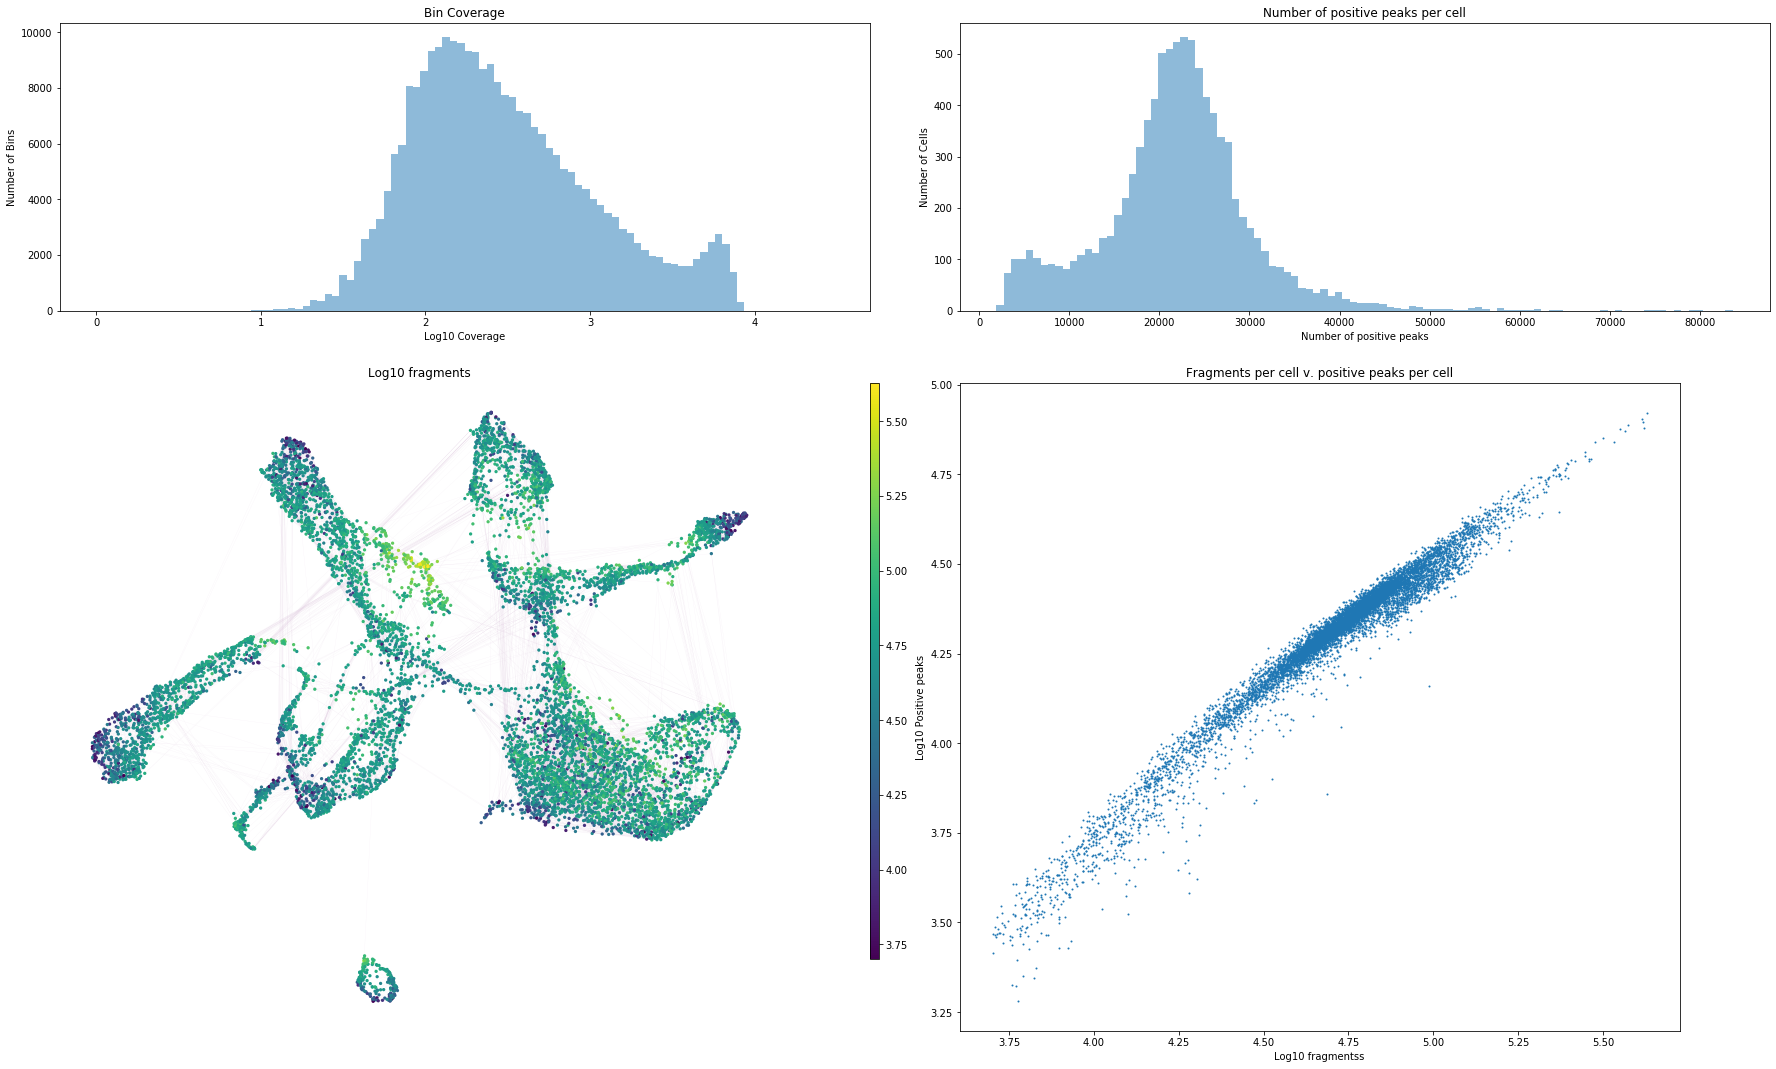

In [15]:
from chromograph.plotting.QC_plot import QC_plot

outdir = '/data/proj/scATAC/chromograph/build_20200216/exported'
f = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
#     manifold2(ds, os.path.join(outdir, f"{ds.attrs['tissue']}_peaks_manifold_cls2_UMAP.png"), embedding = 'UMAP', cls='Clusters2')
#     manifold2(ds, os.path.join(outdir, f"{ds.attrs['tissue']}_peaks_manifold_cls2_TSNE.png"), embedding = 'TSNE', cls='Clusters2')
    QC_plot(ds, os.path.join(outdir, f"{ds.attrs['tissue']}_peaks_manifold_QC.png"), embedding = 'UMAP')

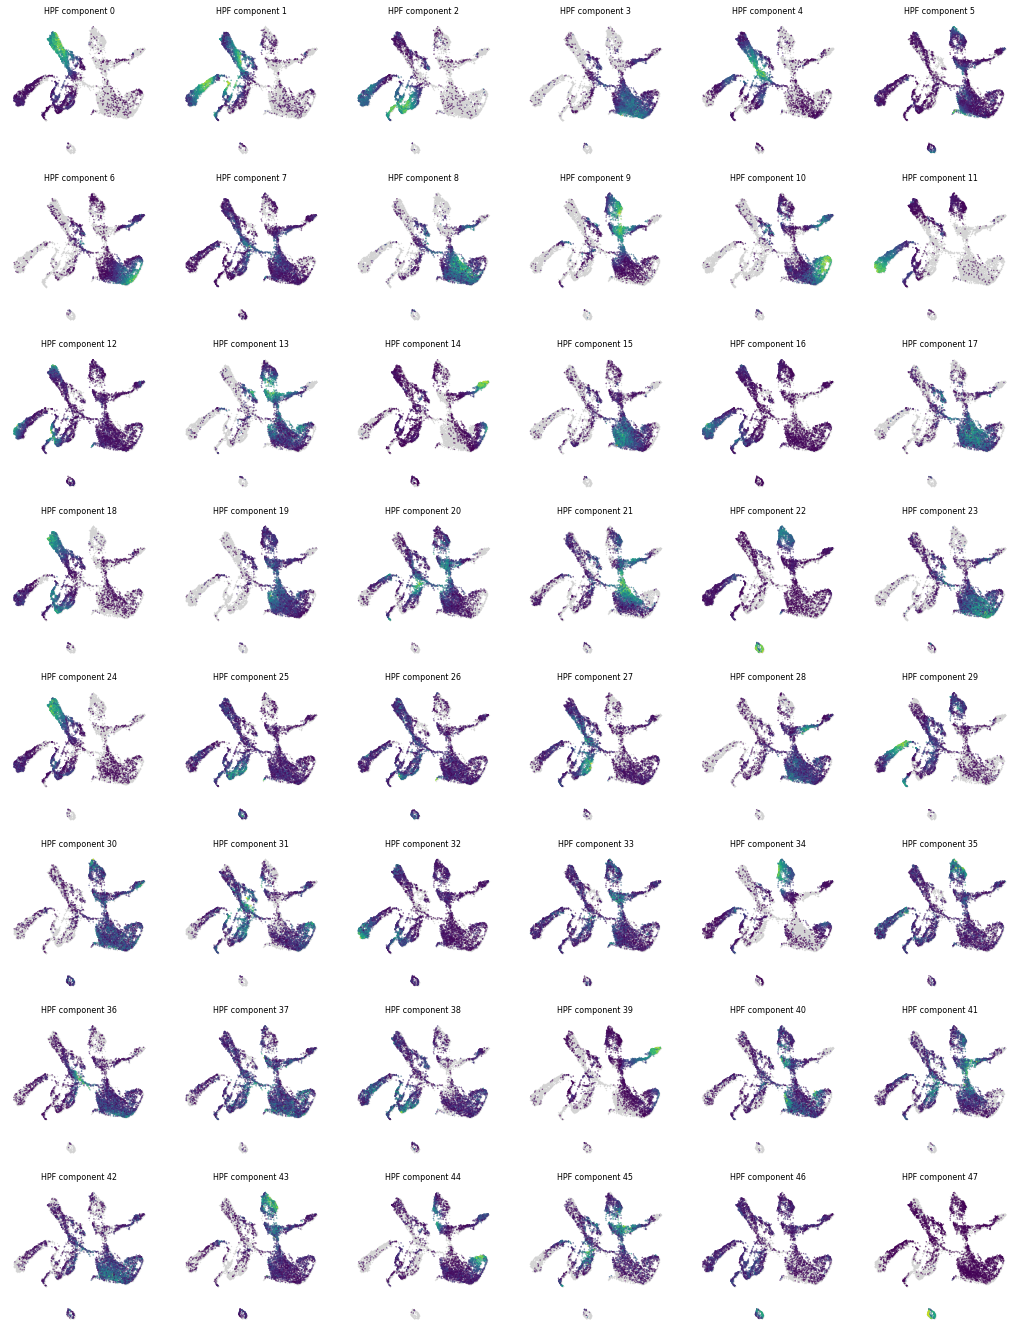

In [27]:
outdir = '/data/proj/scATAC/chromograph/build_20200216/exported'
f = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    ## Plot HPF factors
    fig, ax = plt.subplots(nrows = 8, ncols = 6, figsize=(18,24))

    ncomp = ds.ca.HPF.shape[1]
    mComp = 0.01

    y = -1
    x = 0
    for k in range(ncomp):
        x = k%6
        if x == 0:
            y += 1    

        ax[y,x].scatter(ds.ca['UMAP'][:,0], ds.ca['UMAP'][:,1], s=0.1, color = 'lightgray')

        ck = ds.ca['HPF'][:,k] > mComp
        ax[y,x].scatter(ds.ca['UMAP'][ck,0], ds.ca['UMAP'][ck,1], s=0.1, c=ds.ca['HPF'][ck,k], cmap = 'viridis')
        ax[y,x].set_title(f'HPF component {k}', fontdict={'fontsize': 8, 'fontweight': 'medium'})
        ax[y,x].axis("off")
        
    out_file = os.path.join(outdir, 'HPF_components.png')   
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

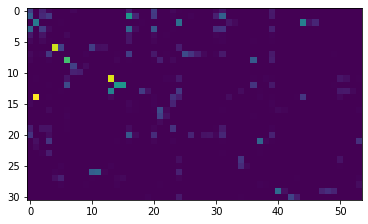

In [52]:
outdir = '/data/proj/scATAC/chromograph/build_20200216/exported'
f = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    c1 = ds.ca['Clusters']
    c2 = ds.ca['Clusters2']
    v = np.zeros([len(np.unique(c2)), len(np.unique(c1))])
    
    for x in range(len(c1)):
        i = c1[x]
        j = c2[x]
        v[j,i] += 1
        
plt.imshow(v)

In [127]:
# markers = ['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 
#            'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 'ETS1',
#            'OLIG2', 'ETV5', 'RX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 
#            'SALL2','HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2',
#            'NEUROD6', 'ZNF33A', 'PHTF1']

markers = np.loadtxt('markers.txt', dtype=str, delimiter=',')
markers = np.array([x.strip() for x in markers])
markers

array(['FOXS1', 'TBX2', 'FOXD1', 'TBX15', 'TBX18', 'FHL5', 'SOX10',
       'OLIG1', 'ZMAT3', 'PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1',
       'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 'NKX2-3', 'HES6',
       'TFDP2', 'NEUROG1', 'DLL1', 'ZBTB18', 'NKX6-2', 'FOXD2', 'SIM1',
       'ZNF521', 'LMO1', 'PROX1', 'KDM5B', 'ZNF441', 'HMX2', 'ZNF300',
       'ZNF25', 'ZNF821', 'MEIS2', 'PRDM6', 'TFAP2B', 'NFIL3', 'ZNF292',
       'ZNF362', 'FEV', 'TBX1', 'ERG', 'SOX18', 'BCL6B', 'SOX17', 'TFEB',
       'SPI1', 'FOXO3', 'IRF8', 'IKZF1 STAT1', 'REL', 'ETV4', 'LHX3',
       'MSX1', 'GABPB2', 'SAMD13', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6',
       'MBD4', 'GTF2H2', 'NEUROD6', 'ZNF33A', 'PHTF1', 'POU4F1', 'ZBED4',
       'ZNF91', 'ZNF124', 'TERF2', 'NFE2L3', 'ZNF57', 'ZFP69B', 'LMO3',
       'DEAF1', 'ZNFX1', 'ZNF813', 'FOXD4L5', 'IKZF3', 'ATRX', 'CITED2',
       'PRDM2', 'CAMTA1', 'LHX4', 'ISL1', 'ESRRB', 'ISL2', 'PHOX2A',
       'PHOX2B', 'EPAS1', 'FOXF2', 'ETS1', 'FOXC1', 'FOXQ1', 'ZIC2',

In [136]:
outdir = '/data/proj/scATAC/chromograph/build_20200216/exported'
f = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'
with loompy.connect(f, 'r') as ds:
    for i in [0, 9, 10, 11, 47]:
        hpf = ds.ra['HPF'][:,i]
        q = np.quantile(hpf, 0.995)
        pks = ds.ra['Gene Name'][hpf > q]
        valid = [x for x in markers if x in pks]
        logging.info(f'For component {i} with q: {q} markers: {valid}')

22:09:28 INFO     For component 0 with q: 0.44218188964872907 markers: ['TBX15', 'FOXC1']
22:09:28 INFO     For component 9 with q: 0.34273946773932656 markers: ['ZMAT3', 'ZEB2', 'ERG', 'HMGB1', 'CAMTA1', 'ETS1', 'FOXC1', 'MEF2C']
22:09:28 INFO     For component 10 with q: 0.2823429529238746 markers: ['IKZF3', 'GLIS3']
22:09:28 INFO     For component 11 with q: 0.46486169755578555 markers: ['JADE1']
22:09:28 INFO     For component 47 with q: 0.3921587807123898 markers: ['ENO1', 'ZNF362', 'ETS1', 'MEF2C']


In [69]:
f = '/data/proj/scATAC/chromograph/build_20200220_Midbrain//Midbrain_peaks.loom'
f2 = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain_GA.loom'
with loompy.connect(f, 'r+') as dsp:
    with loompy.connect(f2, 'r+') as dsg:
        print(dsg.ca.keys())
        dsg.permute(dsg.ca['CellID'].argsort(), axis=1)
        score = 0
        for x in range(dsp.shape[1]):
            if dsp.ca['CellID'][x] == dsg.ca['CellID'][x]:
                score += 1
        print(score)

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'Editat', 'Editby', 'Finalconc', 'GA_colsum', 'Id', 'Idxset', 'Inputmrna', 'Label', 'Method', 'Molarity', 'NBins', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'on_target_fragments', 'passed_filters'